In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import chart_studio.plotly as py
from fluxbot import Fluxbot
import glob
from random import choice


import chart_studio
#chart_studio.tools.set_credentials_file(username='kcaylor', api_key='IbqM6HtGECKogM2wEN12')

## Fluxbot Tests


## Testing CIRAS Data

In the block below, we are creating a `mock` event that will allow us to test and make sure that we can get the same flux calculation from our code as we get from the CIRAS system.


1. Import a CIRAS dataset from fixtures [DONE]
1. Create a mock dataframe from this CIRAS dataset [DONE-ISH] (we need to calculate CO2_mass)
1. Create a mock event using our mocked dataframe that we just made from the CIRAS data.
1. Run the `calculate_flux` function for our mocked event.
1. Compare the output to our CIRAS value.
1. If success, we move on.


In [2]:
from fluxbot import CIRASFluxEvent
from tests.fixtures import CIRAS_test_dict
from tests.test_fluxbot import xldate_as_datetime
import pandas as pd
from fluxbot import order_1_fit, order_2_fit, order_3_fit, Fluxbot

# TEST THE CIRAS DATA TO GET CIRAS RESULTS.

df_CIRAS = pd.DataFrame(CIRAS_test_dict)
df = pd.DataFrame([],columns=['Timestamp','Flux_Event', 'Obs_Interval', 'CO2_mass', 'Pressure', 'Temp', 'Raw.CO2.PPM'])

df['Raw.CO2.PPM'] = df_CIRAS['CO2r'] # in micromol/mol aka PPM
df['Unix.Epoch.Time'] = df_CIRAS['ExcelTime']
df['Timestamp'] = df_CIRAS['ExcelTime'].apply(xldate_as_datetime)
df['Temp'] = df_CIRAS['Tsurface'] # in degrees C
df['Pressure'] = df_CIRAS['Patm'] # in millibars
df['Humidity'] = df_CIRAS['RH'] # in %
df['Flux_Event'] = 1
df['ActuatorState'] = 0
df.index = df['Timestamp']


####
# calculating CO2 mass, from CIRAS-SRC manual:
# 𝑭CO2(g/m2/hr)=(d𝑪μmol/dTmol s)×(𝑷/1013)×(273/273+Tair)×(44.009g/22.414L)×(𝑽 m3/Am2)×(mol/10^6 umol)×(3600s/hr)×(10^3L/m3)
####
# R (output) = taking out the time conversion as this is not a rate right now, which means output is in g/m2
# d𝑪μmol/dTmol = CO2 in ppm (equiv. to μmol/mol)
# P = atmospheric pressure in mbar (=hPa)
# T = temp of the system volume in C
# V = system volume in cm3 (converted to m3)
# A = system volume in cm2 (converted to m2)
df['CO2_mass_CIRAS_gm2'] = df['Raw.CO2.PPM']*((df.Pressure)/1013)*(273/(273+df.Temp))*(44.009/22.414)*((1170*0.000001)/(78*0.0001))*(1/1000000)*(1000)
df['CO2_mass_CIRAS_umolm2'] = df['Raw.CO2.PPM']*((df.Pressure)/1013)*(273/(273+df.Temp))*(1/22.414)*((1170*0.000001)/(78*0.0001))*(1000)

# using conversions from fluxbot.py
df['CO2_mass_fluxbot'] = (df.Pressure/(8.314*(df.Temp+273))*1.2041)*(df['Raw.CO2.PPM']/1000000)*(44.009/1000)*(2758*0.000001)

df.tail()[['CO2_mass_CIRAS_gm2', 'CO2_mass_CIRAS_umolm2', 'CO2_mass_fluxbot']]

ImportError: cannot import name 'CIRASFluxEvent'

In [3]:
def test_FCO2l(calc, df_CIRAS):
    
    # Build a test dataframe from the CIRAS data:
    df = pd.DataFrame([],columns=['Timestamp','Flux_Event', 'Obs_Interval', 'CO2_mass', 'Pressure', 'Temp', 'Raw.CO2.PPM'])

    df['Raw.CO2.PPM'] = df_CIRAS['CO2r'] # in micromol/mol aka PPM
    df['Unix.Epoch.Time'] = df_CIRAS['ExcelTime']
    df['Timestamp'] = df_CIRAS['ExcelTime'].apply(xldate_as_datetime)
    df['Temp'] = df_CIRAS['Tsurface'] # in degrees C
    df['Pressure'] = df_CIRAS['Patm'] # in millibars
    df['Humidity'] = df_CIRAS['RH'] # in %
    df['Flux_Event'] = 1
    df['ActuatorState'] = 0
    df.index = df['Timestamp']


    ####
    # calculating CO2 mass, from CIRAS-SRC manual:
    # 𝑭CO2(g/m2/hr)=(d𝑪μmol/dTmol s)×(𝑷/1013)×(273/273+Tair)×(44.009g/22.414L)×(𝑽 m3/Am2)×(mol/10^6 umol)×(3600s/hr)×(10^3L/m3)
    ####
    # R (output) = taking out the time conversion as this is not a rate right now, which means output is in g/m2
    # d𝑪μmol/dTmol = CO2 in ppm (equiv. to μmol/mol)
    # P = atmospheric pressure in mbar (=hPa)
    # T = temp of the system volume in C
    # V = system volume in cm3 (converted to m3)
    # A = system volume in cm2 (converted to m2)
    df['CO2_mass_CIRAS_gm2'] = df['Raw.CO2.PPM']*((df.Pressure)/1013)*(273/(273+df.Temp))*(44.009/22.414)*((1170*0.000001)/(78*0.0001))*(1/1000000)*(1000)
    df['CO2_mass_CIRAS_umolm2'] = df['Raw.CO2.PPM']*((df.Pressure)/1013)*(273/(273+df.Temp))*(1/22.414)*((1170*0.000001)/(78*0.0001))*(1000)

    # using conversions from fluxbot.py
    df['CO2_mass_fluxbot'] = (df.Pressure/(8.314*(df.Temp+273))*1.2041)*(df['Raw.CO2.PPM']/1000000)*(44.009/1000)*(2758*0.000001)

    test_CIRAS_event = Event(df, number=df['Flux_Event'][0])
    FCO2l = df


In [4]:
########################################################################################################################
# 
#  This is our main analysis cell where we are trying to sort out the calculations and corrections used in the CIRAS
#  flux manual as well as our own ideas around corrections and calculations. 
#
########################################################################################################################

import pandas as pd
import numpy as np
from fluxbot import Event
from fluxbot import order_1_fit, e_star
from fluxbot import Fluxbot
from tests.fixtures import CIRAS_test_dict
from tests.test_fluxbot import xldate_as_datetime

########################################
# SETUP THE CIRAS FLUX TESTS
########################################
CIRAS_VOLUME = 1151 # milliliters or cubic centimeters
CIRAS_AREA = 78 # area of chamber in cm^2

df_CIRAS = pd.DataFrame(CIRAS_test_dict)
# Build a test dataframe from the CIRAS data:
df = pd.DataFrame([],columns=['Timestamp','Flux_Event', 'Obs_Interval', 'CO2_mass', 'Pressure', 'Temp', 'Raw.CO2.PPM'])

df['Raw.CO2.PPM'] = df_CIRAS['CO2r'] # in micromol/mol aka PPM
df['Unix.Epoch.Time'] = df_CIRAS['ExcelTime']
df['Timestamp'] = df_CIRAS['ExcelTime'].apply(xldate_as_datetime)
df['Temp'] = df_CIRAS['Tsurface'] # in degrees C
df['Pressure'] = df_CIRAS['Patm'] # in millibars
df['Humidity'] = df_CIRAS['RH'] # in %
df['Flux_Event'] = 1
df['ActuatorState'] = 0
df.index = df['Timestamp']

df['CO2_conc'] = Fluxbot.gas_ppm_to_conc(df['Raw.CO2.PPM'], df['Pressure'], df['Temp'])
df['CO2_mass'] = Fluxbot.gas_conc_to_mass(df['CO2_conc'], volume=CIRAS_VOLUME)

test_CIRAS_event = Event(df, number=df['Flux_Event'][0], fit_func=order_1_fit)

########################################################################
# Get final CO2 in ppm (umol/mol) and also in mol/mol
########################################################################
C_final_ppm = float(test_CIRAS_event.data['Raw.CO2.PPM'][-1])  # Final CO2 in ppm (umol/mol)
C_final = test_CIRAS_event.data['Raw.CO2.PPM'][-1]*1000000 # Final CO2 in mol/mol

########################################
# INTERCOMPARISON OF METHODS
########################################

# 1. Calcualte the flux using our method (1st order fit):
fCO2l_calc = test_CIRAS_event.calculate_flux(area=CIRAS_AREA, units='umol/m2/s')

# 2. Let's try to calculate the flux using ppm instead of kg:
T = pd.Series((test_CIRAS_event.data.index - test_CIRAS_event.data.index.min()).total_seconds())
T.index = test_CIRAS_event.data.index
C_ppm = test_CIRAS_event.data['Raw.CO2.PPM'] - test_CIRAS_event.get_ambient(
    test_CIRAS_event.raw_df, test_CIRAS_event.number, variable='Raw.CO2.PPM'
)

p1, f, r2 = order_1_fit(T,C_ppm)  # This is doing all the work for fitting our curves...
b = p1[0]  # b is in unit of umol/mol/sec
duration = (test_CIRAS_event.data.index.max() - test_CIRAS_event.data.index.min()).seconds
change_in_ppm = b * duration  # [umol/mol]
P = float(df['Pressure'][0])
T = float(df['Temp'][0])
change_in_kg_m3 = Fluxbot.gas_ppm_to_conc(change_in_ppm, P, T)
change_in_kg = Fluxbot.gas_conc_to_mass(change_in_kg_m3, volume=CIRAS_VOLUME)
change_in_g = change_in_kg * 1000
g_per_mol_CO2 = 44.009 # g/mol
change_in_mol = change_in_g / g_per_mol_CO2
area_m2 = (CIRAS_AREA * 0.0001)
fCO2 = (change_in_mol*1e6) / duration / area_m2   # FINAL ESTIMATE OF RAW FLUX. [umol/m2/s]

fCO2_2 = b * mol_air / area_m2
print("#####################################################################")
print("Original Flux calculation, umol/m2/s: ", fCO2)
print("      ..... Alternative Flux calculation, umol/m2/s: ", fCO2_2)

################################################################################
# Double check our change in mol calculations using the mol_air in chamber:
################################################################################
# Note, we are only doing this to double check our calculations. We prefer "change_in_mol":
# Here's how to get the moles of dry air in the chamber:
rho_a = Fluxbot._air_density(df['Pressure'],df['Temp'])
mol_air = Fluxbot._air_mol_volume(rho_a, volume=CIRAS_VOLUME).mean() # just taking a mean.

change_in_mol_2 = (change_in_ppm * mol_air) / 1000000
print("     ...Change in mol CO2, calculations: ",change_in_mol)
print("     ...Change in mol CO2, using mol air: ",change_in_mol_2)

################################################################################
# Convert change in H2O relative humidity to change in mmol/mol.
################################################################################
# We are:
# 1. using Teten's Equation to determine saturation vapor pressure (in kPa)
# 2. We use RH to determine vapor pressure in kPa
# 3. We divide vapor pressure by total pressure (in kPa!) to get mol/mol.
# 4. We multiply by 1000 to get mmol/mol.

Pinit = (float(df['Pressure'][0])/10)   # Initial Total Pressure in kPa.
Pfinal = (float(df['Pressure'][-1])/10) # Final Total Pressure in kPa
e_star_init = e_star(df['Temp'][0])     # Initial svp in kPa
e_star_final = e_star(df['Temp'][-1])   # Final svp in kPa
e_init_ppm = (((float(df['Humidity'][0])/100)*e_star_init)/Pinit) * 1000000     # Initial H2O in ppm
e_final_ppm = (((float(df['Humidity'][-1])/100)*e_star_final)/Pfinal) * 1000000 # Final H2O in ppm

e_init = (((float(df['Humidity'][0])/100)*e_star_init)/Pinit) * 1000      # Initial H2O in mmol/mol
e_final = (((float(df['Humidity'][-1])/100)*e_star_final)/Pfinal) * 1000  # Final H2O in mmol/mol

#print("H2O initial, final, ppm:")
#print(e_init,e_final)

########################################################################
# Alternatively, determine change in moles of water vapor using change in ppm:
########################################################################
g_per_mol_H2O = 18.01528 # g/mol
change_in_H2O_ppm = e_final_ppm - e_init_ppm   # Change in H2O ppm, in units of ppm.
change_in_H2O_kg_m3 = Fluxbot.gas_ppm_to_conc(change_in_H2O_ppm, P, T, g_per_mol=g_per_mol_H2O)
change_in_H2O_kg = Fluxbot.gas_conc_to_mass(change_in_H2O_kg_m3, volume=CIRAS_VOLUME)
change_in_H2O_g = change_in_H2O_kg * 1000
change_in_mol_H2O = change_in_H2O_g / g_per_mol_H2O
E = change_in_mol_H2O

########################################################################
# Do the Water Vapor Correction (we need to check this still...)
########################################################################
water_vapor_correction = (C_final_ppm * E) / duration / area_m2 # WARNING. WE ARE DOING THIS WRONG.
fCO2_corrected = fCO2 + water_vapor_correction

print("#####################################################################")
print(" Our Correction Factor for Water Vapor ")
print("     ..... Change in H2O, moles: ",E)
print("     ....  Correction term (C_final * E)/duration), [umol/s]:",water_vapor_correction)
print(" Corrected flux [umol/m2/s]: ",fCO2_corrected)

########################################################################
# Do the CIRAS Water Vapor Correction (this is super weird)
########################################################################
E_CIRAS = (e_final - e_init)/(1000 - e_final)
CIRAS_water_vapor_correction = (C_final_ppm * E_CIRAS)
b_CIRAS = b + (CIRAS_water_vapor_correction)

########################################################################
# Convert CIRAS flux in umol/mol/s into umol/m2/s 
########################################################################
P = df['Pressure'][0]
T = df['Temp'][0]
CIRAS_fCO2 = b_CIRAS * P/1013 * 273/(273 + T) * (1/22.4) * (CIRAS_VOLUME/1000000)/(CIRAS_AREA/10000) * 1000
CIRAS_fCO2_raw = b * P/1013 * 273/(273 + T) * (1/22.4) * (CIRAS_VOLUME/1000000)/(CIRAS_AREA/10000) * 1000

print("#####################################################################")
print(" CIRAS Original Flux Calculation [umol/m2/s]: ",CIRAS_fCO2_raw)
print(" CIRAS Correction Factor for Water Vapor ")
print("     ..... CIRAS change in H2O, [mmol/mol]: ",E_CIRAS)
print("     ..... CIRAS correction term [??]: ",CIRAS_water_vapor_correction)
print(" CIRAS corrected flux [umol/mol/s]:", b_CIRAS)
print(" CIRAS corrected flux [umol/m2/s]:", CIRAS_fCO2)
print(" CIRAS corrected flux (using our correction term) [umol/m2/s]: ",CIRAS_fCO2_raw + water_vapor_correction)


ImportError: cannot import name 'order_1_fit'

In [5]:
# print("Change in H2O, moles:")
# print(E)
# print("Change in CO2, moles:")
# print(change_in_mol)
# print("dC/dt (b):")
# print(b)
# print("OUR Correction term (C_final * E)/duration), [umol/s]:")
# water_vapor_correction = (change_in_ppm * E) / duration / area_m2
# print(water_vapor_correction)

# # Flux is estimated using d(ppm)/dt assuming constant W (mol air)
# # But mol air increases by E over duration of observation.
# # Therefore, the flux is slightly larger than we think because same ppm at end of duration is a greater amount of gas.
# # So. We need to increase the flux.
# # Our flux is in umol/m2/sec.
# # But! The amount of vapor increased the number of umols of CO2 that we should have inluded in the flux.
# # The increase in CO2 umols associated with water vapor increases is the change_in_CO2_ppm * mol_change_in_water_vapor.
# # (C_final - C_init)*W + C_final*E
# # ((C_final - C_init)*W)/(W+E)/duration = b
# # f_corrected = b + (C_final*E)/(W)/duration
# # 3. Let's try to calculate the flux using ppm instead of kg and 

# # so the steps are to make the conversion with humidity BEFORE converting to umol/m2/s
# # b is the same: in  PPM (maybe?)
# Cfinal_ppm = float(test_CIRAS_event.data['Raw.CO2.PPM'][len(df['Raw.CO2.PPM'])-1])
# #Cfinal_mol = ((Fluxbot.CO2_conc_to_mass(Fluxbot.CO2_ppm_to_conc(Cfinal_ppm, P, T), volume = CIRAS_VOLUME))*1000)/g_per_mol_CO2

# C_final = test_CIRAS_event.data['Raw.CO2.PPM'][-1]*1000000 # Final CO2 in mol/mol

# E_CIRAS = (e_final - e_init)/(1000 - e_final)

# print(E * test_CIRAS_event.data['Raw.CO2.PPM'][-1])
# print("Change in H2O, moles from eq. :")
# print(E_CIRAS)
# ## need to add a new test function in .py doc that incorporates Humidity

# print(b + C_final * E)

In [8]:
#=np.nan # commented out on Jun. 3, 2020 bc I cannot remember why this is here?

# 4. Extract the final flux estimate from CIRAS data (also uses 1st order fit?):
fCO2l = float(df_CIRAS['FCO2l'][-1:])

print(
    "Event calc (mass):",fCO2l_calc,
    "\nEvent calc (ppm):",fCO2_ppm,
   # "\nEvent calc (ppm w/ RH correction):",flux_ppm_humidity,
    "\nCIRAS Data:",fCO2l)
old_flux = 1.88619867413822

NameError: name 'df_CIRAS' is not defined

### testing known quantities (e.g. known concentrations --> units mass) of CO2 against our functions:

#### CO2 ppm to CO2 concentration, kg/m^3

In [6]:
# concentration of CO2 at 400ppm, 20C, 1atm (1013hPa) --> ~732mg/m^3 = 0.000732 kg/m^3
# concentration of CO2 at 400ppm, 10C, 1atm (1013hPa) --> ~758mg/m^3 = 0.000758 kg/m^3
# concentration of CO2 at 400ppm,  0C, 1atm (1013hPa) --> ~785mg/m^3 = 0.000785 kg/m^3


# PPM = 400 (standard atmospheric)
# pressure = 1013 (hPa, = 1atm)
# temperature = 20C (standard room temp),
    # and 10C,
            # and 0C

CO2_conc_test1 = Fluxbot.CO2_ppm_to_conc(400,1013,20)
CO2_conc_test2 = Fluxbot.CO2_ppm_to_conc(400,1013,10)
CO2_conc_test3 = Fluxbot.CO2_ppm_to_conc(400,1013,0)

print(CO2_conc_test1, CO2_conc_test2, CO2_conc_test3)

# okay so these numbers are not lining up from the get-go!  
# so the issue is in the calculation of PPM --> kg/m3 in our function.

AttributeError: type object 'Fluxbot' has no attribute 'CO2_ppm_to_conc'

#### try new function (CO2_ppm_to_conc_alt)
#### This function comes from the equation in the CIRAS manual

In [7]:
CO2_conc_test4 = Fluxbot.CO2_ppm_to_conc_alt(400,1013,20)

print(CO2_conc_test4)

# okay so the alt version of things works.

# convert co2 concentration to co2 mass:
CO2_mass_test4 = Fluxbot.CO2_conc_to_mass(CO2_conc_test4, volume = 1151)
print(CO2_mass_test4)

AttributeError: type object 'Fluxbot' has no attribute 'CO2_ppm_to_conc_alt'

In [ ]:
# using new alt function, calculate flux from CIRAS data
df['CO2_conc_alt'] = Fluxbot.CO2_ppm_to_conc_alt(df['Raw.CO2.PPM'], df['Pressure'], df['Temp'])

# print(df['CO2_conc_alt'])

df['CO2_mass'] = Fluxbot.CO2_conc_to_mass(df['CO2_conc_alt'], volume=CIRAS_VOLUME)

# print(df['CO2_mass_alt'])

alt_CIRAS_event = Event(df, number=df['Flux_Event'][0], fit_func=order_1_fit)

T = pd.Series((alt_CIRAS_event.data.index - alt_CIRAS_event.data.index.min()).total_seconds())
C = alt_CIRAS_event.data['CO2_mass'] - test_CIRAS_event.ambient

fCO2l_alt = alt_CIRAS_event.calculate_flux(area=CIRAS_AREA, units='umol/m2/s')

fCO2l = df_CIRAS['FCO2l'][-1:]

print(fCO2l_alt)
print(fCO2l)
# print(T)
# print(C)

## conclusions at EOD Weds, May 20, re: above cells of work ^^^
### - the conversion of PPM to concentration was off, so I wasn't able to use the function to produce known CO2 concentrations
### - made a very simple alternative function ("CO2_ppm_to_conc_alt", line 323) to replicate known values
### - applied this 'alt' function to convert PPM to concentration
### - used those newly-calculated concentrations, converted to mass in flux calc 
### BUT the flux it calculated was HUGE (1456578520.36 umol/m2/s) <-- how??

## SO: the flux calculations might also be incorrect somehow.  need to dive into those polynomials next. How is it that similar raw data is getting calculated so differently?  Is it the one-step vs. two-step issue? (see below)

# next step (21st): write new function that calculates slope first (both first and second order) then uses in simpler flux eqn (e.g. Carbone et al. 2011)

In [9]:
# write df to csv
# df.to_csv('formattedCIRASdat.csv')

# moved manually to 'tests' folder
# We want to test our calculation of an event.


# manually renamed: ABCD EF1

# read data
file = glob.glob("{dir}/*.csv".format(dir='testdat'))
data_files = glob.glob("tests/NMWC OM1.csv")
file = choice(data_files)


%CIRAStest_L=Fluxbot(filename=file, event_type='Linear')
%CIRAStest_C=Fluxbot(filename=file, event_type='CIRAS')


CIRAStest_data_L = pd.DataFrame([event.calculate_flux(units='umol/m2/s') for event in CIRAStest_L.events])
CIRAStest_data_C = pd.DataFrame([event.calculate_flux(units='umol/m2/s') for event in CIRAStest_C.events])

ERROR:root:Line magic function `%CIRAStest_L` not found.
ERROR:root:Line magic function `%CIRAStest_C` not found.


NameError: name 'CIRAStest_L' is not defined

In [ ]:
# okay now we have the separate issue of it using the wrong volume and area so need to figure that out
event = CIRAStest_L.events[1]

# Test code to look at our Mpala data

## Let's look at one file first

In [10]:
# Pick a fluxbot at random
data_files = glob.glob("{dir}/*.csv".format(dir='data'))
file = choice(data_files)

fluxbot_C=Fluxbot(filename=file, event_type='CIRAS')
fluxbot_S=Fluxbot(filename=file, event_type='Simple')
fluxbot_L=Fluxbot(filename=file, event_type='Linear')

# Get the estiamted flux for each event in this fluxbot using implicit for loop:
flux_data_C = pd.DataFrame([event.calculate_flux(units='umol/m2/s') for event in fluxbot_C.events])
flux_data_S = pd.DataFrame([event.calculate_flux(units='umol/m2/s') for event in fluxbot_S.events])
flux_data_L = pd.DataFrame([event.calculate_flux(units='umol/m2/s') for event in fluxbot_L.events])

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# flux_data_S.hist()
# flux_data_C.hist()
# flux_data_L.hist()

event = fluxbot_L.events[100]

In [ ]:
print(p1[0], p2[0], p3[0])
print(p2, p3)


In [ ]:
from fluxbot import order_1_fit, order_2_fit, order_3_fit

event = fluxbot_L.events[100]

T = event.data['Unix.Epoch.Time'] - event.data['Unix.Epoch.Time'].min()
# set C: C' = C - C_ambient
C = event.data['CO2_mass'] - event.ambient


print((event.data.index.max() - event.data.index.min()).seconds)

p1, f1 = order_1_fit(T,C)

p2, f2 = order_2_fit(T,C)

p3, f3 = order_3_fit(T,C)




In [ ]:

def R_sq(y,f):
	""" Calculates the coefficient of determination

		R^2 = 1 - (SS_res/SS_tot)

		where:
			SS_tot = np.sum((y-np.mean(y))**2)
			SS_res = np.sum((y-f)**2)


	Prameters
	=========

	y: np.array
		values
	f: np.array
		predicted values

	Returns
	=======
	R_sq: float
		Coefficient of Determination
	"""

	SS_tot = np.sum((y-np.mean(y))**2)
	SS_res = np.sum((y-f)**2)
	R_sq = 1 - SS_res/SS_tot

	return R_sq


In [ ]:
R_sq(C,f3)



In [ ]:
print(p2[0]*300)

plt.figure()
plt.plot(C, '.')
plt.plot(f1,'-')
plt.title('Linear Fit')

plt.figure()
plt.plot(C-f1)
plt.title('Linear Residuals')


plt.figure()
plt.plot(C, '.')
plt.plot(f2,'-')
plt.title('2nd Order Fit')

plt.figure()
plt.plot(C-f2)
plt.title('2nd Order Residuals')

plt.figure()
plt.plot(C, '.')
plt.plot(f3,'-')
plt.title('3rd Order Fit')

plt.figure()
plt.plot(C-f3)
plt.title('3rd Order Residuals')



#print(np.mean(C-f1))
#print(np.mean(C-f2))

### THoughts



In [ ]:
n=1
param_initial = [0.5 for i in range(n)]
tuple(param_initial)

In [ ]:
diff = pd.DataFrame(flux_data_S - flux_data_C)
diff.hist()

In [ ]:
idx_max_diff = int(diff.loc[diff[0] == diff[0].max()].index.asi8)

outlier_C = fluxbot_C.events[idx_max_diff+100]
outlier_S = fluxbot_S.events[idx_max_diff+100]

plt.figure()
# outlier.data.columns
plt.plot(outlier_C.data['Unix.Epoch.Time'], outlier_C.data['Raw.CO2.PPM'])
plt.plot(outlier_S.data['Unix.Epoch.Time'], outlier_S.data['Raw.CO2.PPM'])

print(fluxbot_C.title)

print('CIRAS:',fluxbot_C.events[idx_max_diff].calculate_flux(units='umol/m2/s'))
print('Simple:',fluxbot_S.events[idx_max_diff].calculate_flux(units='umol/m2/s'))

In [ ]:
d = outlier_C.data['Raw.CO2.PPM']
d = d - 150
d.plot()

In [ ]:
plt.figure()
plt.plot(flux_data_C, flux_data_S, '.')
plt.plot([0, 18],[0, 18],'-')
plt.xlabel('CIRAS Flux Calculation')
plt.ylabel('Simple Flux Calculation')
plt.title('{title}'.format(title=fluxbot_C.title))
#flux_data.hist()

## Or let's look at all the data right now!

Warning: Can take awhile. Maybe don't do this if you are in a hurry.

In [2]:
# Pick a fluxbot at random
data_files = glob.glob("{dir}/*.csv".format(dir='data'))

all_fluxbots = []
all_flux_data = {}
for file in data_files:
    # Create a fluxbot instance.
    all_flux_bots.append(Fluxbot(filename=file))   
#    all_flux_data[file] = pd.DataFrame([event.calculate_flux(units='umol/m2/s') for event in fluxbot.events])

Using default fluxbot volume 2758
Using default fluxbot area 145.5


/Users/kellycaylor/Documents/dev/fluxbots/fluxbot_05_08.py:357: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 145.5
Using default fluxbot volume 2758
Using default fluxbot area 1

# Testing for 2nd order coefficients in our flux observation data

The code below will take a single fluxbot and analyze every observation interval. We will fit both a linear and a 2nd order polynomial to the data in each observation interval using `order_1_fit` and `order_2_fit` functions in the `fluxbot.py` code. We will then assign these values for each event in the fluxbot.



In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import chart_studio.plotly as py
from fluxbot import Fluxbot
import glob
from random import choice


import chart_studio
chart_studio.tools.set_credentials_file(username='kcaylor', api_key='IbqM6HtGECKogM2wEN12')

## Choose a random fluxbot to analyze

This takes a lot of time to do now because we are doing polynomial fits for each event when we create the events.


In [2]:
data_files = glob.glob("{dir}/*.csv".format(dir='data'))
from random import choice

fluxbot = Fluxbot(filename=choice(data_files))

Using default fluxbot volume 2758
Using default fluxbot area 145.5


/Users/kellycaylor/Documents/dev/fluxbots/fluxbot.py:60: RuntimeWarning:

invalid value encountered in double_scalars



## Calculate fits for linear, 2nd order, and 3rd order polynomials and display the coefficients/R^2 values

<Northern O Plot, Under Tree Replicate 1.Fluxbot object at 0x7f93685e0898
Flux: 2.0055241356911986 umol/m2/s
1st order: [1.16465726e-09], R^2: 0.9201693989562851
2nd order: [ 1.28419918e-09 -5.33968748e-13], R^2: 0.9229466919932316
3rd order: [ 1.41889697e-09 -2.03814426e-12  3.77936361e-15], R^2: 0.9235763493321183


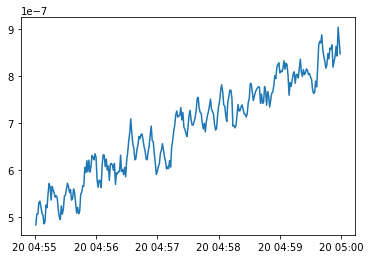

In [30]:
import matplotlib.pyplot as plt
print(fluxbot)
event_num = 900
betas_1st_order  = fluxbot.events[event_num].betas_1st_order
r2_1st_order = fluxbot.events[event_num].R2_1st_order

betas_2nd_order  = fluxbot.events[event_num].betas_2nd_order
r2_2nd_order = fluxbot.events[event_num].R2_2nd_order

betas_3rd_order  = fluxbot.events[event_num].betas_3rd_order
r2_3rd_order = fluxbot.events[event_num].R2_3rd_order

print('Flux: {0} umol/m2/s'.format(fluxbot.events[event_num].calculate_flux(units='umol/m2/s')))
      
# Plot?
plt.plot(fluxbot.events[event_num].data.index, fluxbot.events[event_num].data['CO2_mass'])

print('1st order: {0}, R^2: {1}'.format(betas_1st_order, r2_1st_order))
print('2nd order: {0}, R^2: {1}'.format(betas_2nd_order, r2_2nd_order))
print('3rd order: {0}, R^2: {1}'.format(betas_3rd_order, r2_3rd_order))

2.3958801417e-09

In [12]:
# Let's try to save all the fluxbots into a binary file we can reload later:
import pickle
filehandler = open('all_fluxbots.pickle', 'w')
pickle.dump(all_flux_bots, filehandler)

TypeError: write() argument must be str, not bytes

In [ ]:
# If that worked, then we can simply load the pickled data:
import pickle
filehandler = open('all_fluxbots.pickle', 'r')
all_fluxbots = pickle.load(filehandler)

### Savage et al. 2008: rolling regression to calculate slope
In this paper, the authors used a rolling, overlapping, linear least-squares regression method to determine best-fit for slopes of their CO2 accumulation curves. 

I suggest we use 120s windows, advanced 30s per regression, for all 5 mins (7 total regressions). Then calculate R2 for each regression, only accepting those >90%, and take the highest R2 of all remaining as representative of the event's slope.

We probably need to visually inspect a random selection of accumulation curves to make sure 2mins is large enough of a window to accurately predict slope over the whole 5mins.